####H. Build a Random Forest Model

**Initiate new Spark session.**

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Employee_Attrition_Part_4').getOrCreate()

**Import numpy, pandas, and data visualization libraries.**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Import churn modeling CSV file into PySpark dataframe called churn_model2.**

In [7]:
churn_model2 = spark.read.csv('/FileStore/tables/churn_modeling_data.csv', inferSchema=True, header=True)

**Check number of rows and columns in churn_model2 dataframe.**

In [9]:
print(churn_model2.count(), len(churn_model2.columns))

1470 11

**View structure of churn_model2 dataframe.**

In [11]:
churn_model2.printSchema()

root
-- Churn: integer (nullable = true)
-- Age: integer (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- Sales_Rep: integer (nullable = true)
-- Single: integer (nullable = true)
-- BusTravLevel: integer (nullable = true)
-- Overtime_Dum: integer (nullable = true)

**View first five rows of churn_model2 dataframe.**

In [13]:
display(churn_model2.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,41,1,1,2,5993,0,0,1,1,1
0,49,8,2,1,5130,1,0,0,2,0
1,37,2,3,1,2090,0,0,1,1,1
0,33,3,3,2,2909,0,0,0,2,1
0,27,2,0,2,3468,1,0,0,1,0


**Convert predictor features into vector column using VectorAssembler.**

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [16]:
assembler = VectorAssembler(inputCols=['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum'], outputCol='features')

In [17]:
churn_model2_vect = assembler.transform(churn_model2)
display(churn_model2_vect.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features
1,41,1,1,2,5993,0,0,1,1,1,"List(1, 10, List(), List(41.0, 1.0, 1.0, 2.0, 5993.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,49,8,2,1,5130,1,0,0,2,0,"List(1, 10, List(), List(49.0, 8.0, 2.0, 1.0, 5130.0, 1.0, 0.0, 0.0, 2.0, 0.0))"
1,37,2,3,1,2090,0,0,1,1,1,"List(1, 10, List(), List(37.0, 2.0, 3.0, 1.0, 2090.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
0,33,3,3,2,2909,0,0,0,2,1,"List(1, 10, List(), List(33.0, 3.0, 3.0, 2.0, 2909.0, 0.0, 0.0, 0.0, 2.0, 1.0))"
0,27,2,0,2,3468,1,0,0,1,0,"List(1, 10, List(), List(27.0, 2.0, 0.0, 2.0, 3468.0, 1.0, 0.0, 0.0, 1.0, 0.0))"


**Tune number of trees in random forest model.**

In [19]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [20]:
train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=100)
acc_eval = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')

In [21]:
tree_range = range(10, 130, 10)

In [22]:
acc_scores3 = []

In [23]:
for tree in tree_range:
  rfc1 = RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=tree)
  rfc1_model = rfc1.fit(train_model_data)
  rfc1_predictions = rfc1_model.transform(test_model_data)
  acc_scores3.append(acc_eval.evaluate(rfc1_predictions))

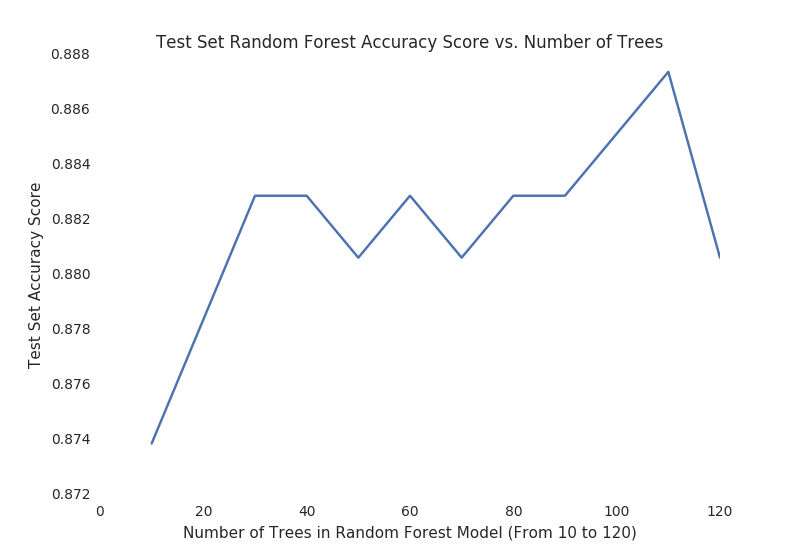

In [24]:
rfc_max_trees, ax = plt.subplots()
ax.plot(tree_range, acc_scores3)
ax.set_xlabel('Number of Trees in Random Forest Model (From 10 to 120)')
ax.set_ylabel('Test Set Accuracy Score')
ax.set_title('Test Set Random Forest Accuracy Score vs. Number of Trees')
display(rfc_max_trees)

In [25]:
dict(zip(tree_range, acc_scores3))

Out[ 16 ]: 
{100: 0.8851351351351351,
 70: 0.8806306306306306,
 40: 0.8828828828828829,
 10: 0.8738738738738738,
 110: 0.8873873873873874,
 80: 0.8828828828828829,
 50: 0.8806306306306306,
 20: 0.8783783783783784,
 120: 0.8806306306306306,
 90: 0.8828828828828829,
 60: 0.8828828828828829,
 30: 0.8828828828828829}

* The maximum number of trees for the random forest model should be 110 since that number corresponds with a maximum test set accuracy score of 0.887.

**Decide which random state seed number will produce the highest accuracy score for a random forest model whose maximum number of trees is 110.**

In [28]:
rfc2 = RandomForestClassifier(labelCol='Churn', featuresCol='features', numTrees=110)

In [29]:
number_range = range(100, 106)

In [30]:
acc_scores4 = []

In [31]:
for number in number_range:
  train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=number)
  rfc2_model = rfc2.fit(train_model_data)
  rfc2_predictions = rfc2_model.transform(test_model_data)
  acc_scores4.append(acc_eval.evaluate(rfc2_predictions))

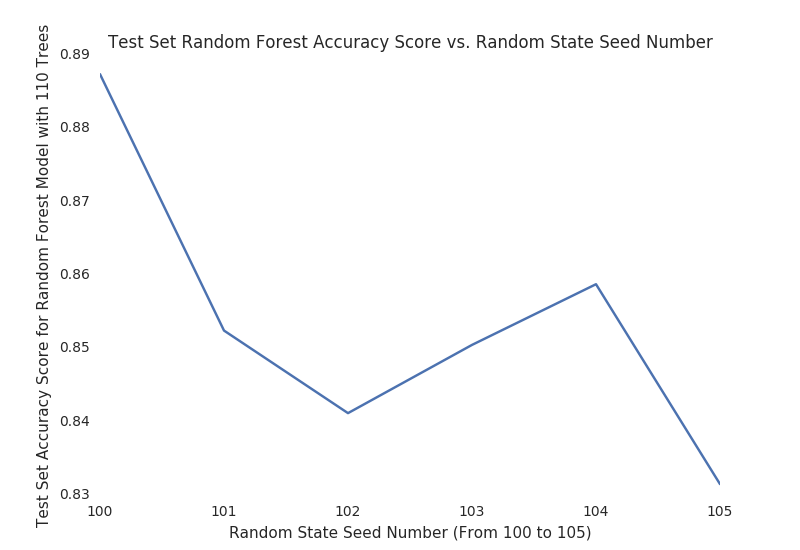

In [32]:
rfc_acc_seed, ax = plt.subplots()
ax.plot(number_range, acc_scores4)
ax.set_xlabel('Random State Seed Number (From 100 to 105)')
ax.set_ylabel('Test Set Accuracy Score for Random Forest Model with 110 Trees')
ax.set_title('Test Set Random Forest Accuracy Score vs. Random State Seed Number')
display(rfc_acc_seed)

In [33]:
dict(zip(number_range, acc_scores4))

Out[ 22 ]: 
{100: 0.8873873873873874,
 101: 0.8524229074889867,
 102: 0.8411633109619687,
 103: 0.8504672897196262,
 104: 0.8587443946188341,
 105: 0.8314855875831486}

* 100 is the random state seed number that will produce the highest test set accuracy score for the random forest model with 110 trees.

**Split churn / attrition modeling data into training and test sets.**

In [36]:
train_model_data, test_model_data = churn_model2_vect.randomSplit([0.7, 0.3], seed=100)

In [37]:
print(churn_model2_vect.count(), len(churn_model2_vect.columns))
print(train_model_data.count(), len(train_model_data.columns))
print(test_model_data.count(), len(test_model_data.columns))

1470 12
1026 12
444 12

**Fit a random forest model with 110 trees on training data set.**

In [39]:
rfc3_model = rfc2.fit(train_model_data)

**Make predictions on test data set and calculate accuracy score.**

In [41]:
rfc3_predictions = rfc3_model.transform(test_model_data)
print('Test Set Accuracy Score for Random Forest Model with 110 Trees: ', acc_eval.evaluate(rfc3_predictions))

Test Set Accuracy Score for Random Forest Model with 110 Trees: 0.8873873873873874

**Compute test set null accuracy score manually.**

In [43]:
from pyspark.sql.functions import col, avg
rfc3_predictions.agg(1 - avg(col('Churn'))).show()

+------------------+
 (1 - avg(Churn))|
+------------------+
0.8626126126126126|
+------------------+

**List out random forest model predictor features and their respective importances.**

In [45]:
feature_cols = ['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
dict(zip(feature_cols, rfc3_model.featureImportances))

Out[ 28 ]: 
{'Sales_Rep': 0.025015446480608713,
 'StockOptionLevel': 0.064164737505749025,
 'MonthlyIncome': 0.22833241532530585,
 'EnvironmentSatisfaction': 0.089033839149456381,
 'Age': 0.15662896394058085,
 'Single': 0.045484263139519705,
 'JobInvolvement': 0.068114758372369619,
 'Overtime_Dum': 0.17860366032330346,
 'BusTravLevel': 0.036668883993408508,
 'DistanceFromHome': 0.10795303176969775}

**Calculate number of true negatives, false positives, false negatives, and true positives in test data set, which is all four figures that comprise a confusion matrix.**

In [47]:
print('True Negatives: ', rfc3_predictions.filter((rfc3_predictions['Churn'] == 0) & (rfc3_predictions['prediction'] == 0)).count())
print('False Positives: ', rfc3_predictions.filter(rfc3_predictions['Churn'] < rfc3_predictions['prediction']).count())
print('False Negatives: ', rfc3_predictions.filter(rfc3_predictions['Churn'] > rfc3_predictions['prediction']).count())
print('True Positives: ', rfc3_predictions.filter((rfc3_predictions['Churn'] == 1) & (rfc3_predictions['prediction'] == 1)).count())

True Negatives: 382
False Positives: 1
False Negatives: 49
True Positives: 12

**Manually calculate accuracy score and misclassification / error rate, precision, recall / sensitivity, and specificity.**

In [49]:
print('Accuracy Score: ', float(382 + 12) / float(382 + 1 + 49 + 12))
print('Misclassification / Error Rate: ', float(1 + 49) / float(382 + 1 + 49 + 12))
print('Precision: ', float(12) / float(1 + 12))
print('Recall / Sensitivity: ', float(12) / float(49 + 12))
print('Specificity: ', float(382) / float(382 + 1))

Accuracy Score: 0.8873873873873874
Misclassification / Error Rate: 0.11261261261261261
Precision: 0.9230769230769231
Recall / Sensitivity: 0.19672131147540983
Specificity: 0.9973890339425587

* Precision measures how confident the training set random forest model captures the positives. Recall / sensivity measures how well the training set random forest model captures the positives. Specificity measures how well the training set random forest model captures the negatives.

**List out false positives in test data set.**

In [52]:
targ_feat_cols = ['Churn', 'prediction', 'Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum']
display(rfc3_predictions.filter(rfc3_predictions['Churn'] < rfc3_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
0,1.0,28,1,3,2,2154,0,0,1,2,1


**List out false negatives in test data set.**

In [54]:
display(rfc3_predictions.filter(rfc3_predictions['Churn'] > rfc3_predictions['prediction']).select(targ_feat_cols))

Churn,prediction,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,0.0,19,2,0,1,2564,0,0,1,1,0
1,0.0,20,2,2,1,2044,0,1,1,1,0
1,0.0,21,10,0,1,2625,0,0,1,2,0
1,0.0,21,10,2,1,1416,0,0,1,1,0
1,0.0,21,12,2,3,2716,0,1,1,1,0
1,0.0,22,3,1,2,4171,1,0,0,1,1
1,0.0,24,1,0,2,3202,0,1,1,1,1
1,0.0,26,21,0,2,2377,1,0,0,1,0
1,0.0,28,5,2,2,3441,0,0,1,1,1
1,0.0,28,13,3,2,9854,0,0,1,1,1


**To change predicted probability threshold to balance sensitivity and specificity, extract predicted probability of churn for each employee from vectorized probability column and generate new predicted class based off new threshold.**

In [56]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
second_vec_element = udf(lambda v: float(v[1]), FloatType())

In [57]:
rfc3_pred_prob = rfc3_predictions.withColumn('pred_prob', second_vec_element(rfc3_predictions['probability'])).withColumn('pred_class', F.when(col('pred_prob') > 0.15, 1).otherwise(0))
display(rfc3_pred_prob.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features,rawPrediction,probability,prediction,pred_prob,pred_class
0,19,3,1,2,1483,0,0,1,1,0,"List(1, 10, List(), List(19.0, 3.0, 1.0, 2.0, 1483.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(63.16281528461944, 46.83718471538056))","List(1, 2, List(), List(0.5742074116783585, 0.42579258832164146))",0.0,0.4257925748825073,1
0,20,1,3,1,2836,0,0,1,1,0,"List(1, 10, List(), List(20.0, 1.0, 3.0, 1.0, 2836.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(79.02274959308963, 30.977250406910365))","List(1, 2, List(), List(0.7183886326644512, 0.28161136733554876))",0.0,0.2816113531589508,1
0,20,2,2,2,2783,0,1,1,1,0,"List(1, 10, List(), List(20.0, 2.0, 2.0, 2.0, 2783.0, 0.0, 1.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(77.16793080544052, 32.83206919455948))","List(1, 2, List(), List(0.701526643685823, 0.2984733563141771))",0.0,0.2984733581542969,1
0,20,3,0,1,3033,0,0,1,1,0,"List(1, 10, List(), List(20.0, 3.0, 0.0, 1.0, 3033.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(65.37994785142318, 44.62005214857679))","List(1, 2, List(), List(0.5943631622856654, 0.40563683771433456))",0.0,0.40563684701919556,1
0,21,5,2,2,3117,0,0,1,1,0,"List(1, 10, List(), List(21.0, 5.0, 2.0, 2.0, 3117.0, 0.0, 0.0, 1.0, 1.0, 0.0))","List(1, 2, List(), List(80.02986241454263, 29.970137585457344))","List(1, 2, List(), List(0.7275442037685695, 0.27245579623143046))",0.0,0.27245578169822693,1


**Using new threshold, calculate number of true negatives, false positives, false negatives, and true positives in test data set, which is all four figures that comprise a confusion matrix.**

In [59]:
print('True Negatives: ', rfc3_pred_prob.filter((rfc3_pred_prob['Churn'] == 0) & (rfc3_pred_prob['pred_class'] == 0)).count())
print('False Positives: ', rfc3_pred_prob.filter(rfc3_pred_prob['Churn'] < rfc3_pred_prob['pred_class']).count())
print('False Negatives: ', rfc3_pred_prob.filter(rfc3_pred_prob['Churn'] > rfc3_pred_prob['pred_class']).count())
print('True Positives: ', rfc3_pred_prob.filter((rfc3_pred_prob['Churn'] == 1) & (rfc3_pred_prob['pred_class'] == 1)).count())

True Negatives: 267
False Positives: 116
False Negatives: 16
True Positives: 45

**Manually calculate recall / sensitivity and specificity, and check whether sensitivity and specificity are balanced with one another.**

In [61]:
print('Recall / Sensitivity: ', float(45) / float(16 + 45))
print('Specificity: ', float(267) / float(267 + 116))

Recall / Sensitivity: 0.7377049180327869
Specificity: 0.6971279373368147

* 0.15 is the best predicted probability threshold to balance sensitivity and specificity with one another.

**Generate training set random forest models using 10-fold cross-validation.**

In [64]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [65]:
paramGrid = (ParamGridBuilder().addGrid(rfc2.maxDepth, [2, 4, 6]).addGrid(rfc2.maxBins, [20, 60]).addGrid(rfc2.numTrees, [30, 110]).build())
cv = CrossValidator(estimator=rfc2, estimatorParamMaps=paramGrid, evaluator=acc_eval, numFolds=10)
cv_rfc_model = rfc2.fit(train_model_data)

**Compute test set accuracy score for best cross-validation model.**

In [67]:
cv_rfc_predictions = cv_rfc_model.transform(test_model_data)
print('Best Cross-Validation Test Set Random Forest Model Metrics')
print('Test Set Accuracy Score: ', acc_eval.evaluate(cv_rfc_predictions))

Best Cross-Validation Test Set Random Forest Model Metrics
Test Set Accuracy Score: 0.8873873873873874